<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [4]:
from google.colab import drive

drive._mount('/content/gdrive')

Mounted at /content/gdrive


Create array with Path objects to imgs

In [5]:
path = Path(f"{dataset_path}")

In [6]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350),
    batch_tfms=Normalize.from_stats(*imagenet_stats))

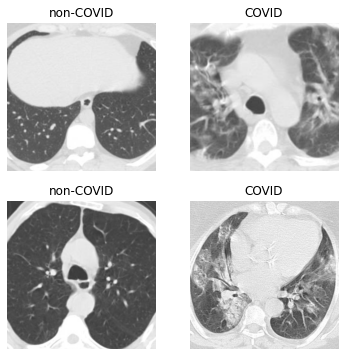

In [7]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

## Inference

Load the model from URL

In [8]:

res34 = load_learner(f'{folder_path}res34.pkl')
res34_con = load_learner(f'{folder_path}res34_con.pkl')
res34_noise = load_learner(f'{folder_path}res34_noise.pkl')


In [9]:
class Ensemble:
  def __init__(self, models : dict, vocab : list=[0, 1], dl=None):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std[0]
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl:
      self.dl = dl
      
    if self.dl is None:
      print('No dataloader')
      return

    predictions = []
    losses = []
    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=self.dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    print()
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds()
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res


In [10]:
en = Ensemble({'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=dls.valid.vocab, dl=dls.valid)
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-COVID', 'COVID']
loaded: res34
loaded: res34_con
loaded: res34_noise


In [11]:
en.calc_probas(f"{dataset_path}/non-COVID/Non-Covid (200).png")

TensorBase([[0.2496, 0.7504],
        [0.0068, 0.9932],
        [0.9866, 0.0134]])

In [12]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase([0.4143, 0.5857]), TensorBase(0.5102))

In [13]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0068, 0.9932]))

In [14]:
# inputs, predictions, targs, decoded, losses = en.get_preds(with_input=True, with_loss=True, with_decoded=True, act=None)

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


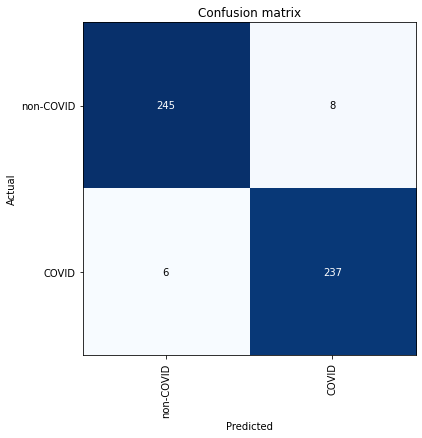

In [15]:
interp = ClassificationInterpretation.from_learner(en, dl=dls.valid)  # -> calls get_preds
# interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

In [16]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

Getting predictions from res34


Getting predictions from res34_con


Getting predictions from res34_noise


{'F1Score': 0.9713114754098362, 'Recall': 0.9753086419753086}

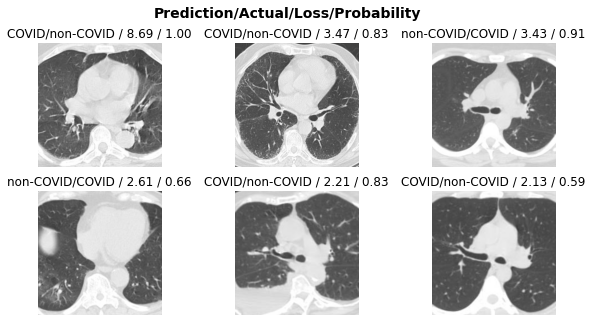

In [17]:
interp.plot_top_losses(6, figsize=(10,5))

In [18]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU" -O res34.pkl && rm -rf /tmp/cookies.txt &> 2

--2021-12-28 14:07:33--  https://docs.google.com/uc?export=download&confirm=3nYI&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU
Resolving docs.google.com (docs.google.com)... 74.125.124.102, 74.125.124.113, 74.125.124.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-as-docs.googleusercontent.com/docs/securesc/2b9o89b24f4452a36edkunl3vet6fcse/jbqhtskocv2udpqgnh079pgr9h9gotsr/1640700450000/05955112456020216338/02776643236744569725Z/151TwzuC8exmzntoh-iQDXPJT71A1CcGU?e=download [following]
--2021-12-28 14:07:33--  https://doc-10-as-docs.googleusercontent.com/docs/securesc/2b9o89b24f4452a36edkunl3vet6fcse/jbqhtskocv2udpqgnh079pgr9h9gotsr/1640700450000/05955112456020216338/02776643236744569725Z/151TwzuC8exmzntoh-iQDXPJT71A1CcGU?e=download
Resolving doc-10-as-docs.googleusercontent.com (doc-10-as-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting